In [1]:
from aind_large_scale_prediction.generator.utils import (
    concatenate_lazy_data, recover_global_position, unpad_global_coords)
from aind_large_scale_prediction.io import ImageReaderFactory
from aind_large_scale_prediction.generator.dataset import create_data_loader
import numpy as np
import logging
from aind_brain_segmentation.model.network import Neuratt
import multiprocessing

target_size_mb = 2048
n_workers = 0
super_chunksize = None#(200, 1024, 928)
scale = 3
smartspim_id = "782646"
image_path = "s3://aind-open-data/SmartSPIM_782646_2025-02-21_16-55-46_stitched_2025-03-06_08-22-36/image_tile_fusing/OMEZarr/Ex_639_Em_667.zarr"
#"s3://aind-open-data/SmartSPIM_780343_2025-02-18_12-34-40_stitched_2025-02-25_08-15-10/image_tile_fusing/OMEZarr/Ex_639_Em_667.zarr"
# "s3://aind-open-data/SmartSPIM_782746_2025-02-10_15-15-28_stitched_2025-02-25_08-50-23/image_tile_fusing/OMEZarr/Ex_639_Em_667.zarr"
# "s3://aind-open-data/SmartSPIM_782744_2025-02-10_10-02-32_stitched_2025-02-25_09-53-12/image_tile_fusing/OMEZarr/Ex_639_Em_667.zarr"
# "s3://aind-open-data/SmartSPIM_780343_2025-02-18_12-34-40_stitched_2025-02-25_08-15-10/image_tile_fusing/OMEZarr/Ex_639_Em_667.zarr"
#'s3://aind-open-data/SmartSPIM_729674_2024-12-16_12-16-28_stitched_2024-12-18_07-35-30/image_tile_fusing/OMEZarr/Ex_639_Em_680.zarr'
#'s3://aind-open-data/SmartSPIM_761339_2025-01-10_21-19-15_stitched_2025-01-12_05-39-33/image_tile_fusing/OMEZarr/Ex_488_Em_525.zarr'
checkpoint_path = "/data/best_model_097_2d.ckpt"
#"/results/whole_brain_seg/whole_brain_seg/cymgslil/checkpoints/best_model.ckpt"

# "/scratch/latest_best_model_smartspim_clamp_int.ckpt"
#"/data/smartspim_brain_seg_models/whole_brain_seg/whole_brain_seg/cfelpja3/checkpoints/best_model.ckpt"

device = None

pin_memory = True
if device is not None:
    pin_memory = False
    multiprocessing.set_start_method("spawn", force=True)
    
axis_pad = 0
overlap_prediction_chunksize = (axis_pad, axis_pad, axis_pad)

lazy_data = (
    ImageReaderFactory()
    .create(data_path=str(image_path), parse_path=False, multiscale=scale)
    .as_dask_array()
)

prediction_chunksize = (4, lazy_data.shape[-2], lazy_data.shape[-1])

logger = logging.Logger(name="log")

print("Loaded lazy data: ", lazy_data)
batch_size = 1
dtype = np.float32
zarr_data_loader, zarr_dataset = create_data_loader(
    lazy_data=lazy_data,
    target_size_mb=target_size_mb,
    prediction_chunksize=prediction_chunksize,
    overlap_prediction_chunksize=overlap_prediction_chunksize,
    n_workers=n_workers,
    batch_size=batch_size,
    dtype=dtype,  # Allowed data type to process with pytorch cuda
    super_chunksize=super_chunksize,
    lazy_callback_fn=None,  # partial_lazy_deskewing,
    logger=logger,
    device=device,
    pin_memory=pin_memory,
    override_suggested_cpus=False,
    drop_last=True,
    locked_array=False,
)

# Creating model
segmentation_model = Neuratt()

if checkpoint_path:
    print(f"Loading path from {checkpoint_path}")
    segmentation_model = Neuratt.load_from_checkpoint(checkpoint_path)

total_batches = sum(zarr_dataset.internal_slice_sum) / batch_size
print("Total batches: ", total_batches, zarr_dataset.lazy_data.shape)

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.



Loaded lazy data:  dask.array<from-zarr, shape=(1, 1, 464, 1280, 928), dtype=uint16, chunksize=(1, 1, 128, 128, 128), chunktype=numpy.ndarray>
Estimating super chunksize. Provided super chunksize: None - Target MB: 2048
Estimated chunksize to fit in memory 2048 MiB: (464, 1280, 928)


monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().


Loading path from /data/best_model_097_2d.ckpt
Total batches:  116.0 (464, 1280, 928)


In [2]:
lazy_data

dask.array<from-zarr, shape=(1, 1, 464, 1280, 928), dtype=uint16, chunksize=(1, 1, 128, 128, 128), chunktype=numpy.ndarray>

In [3]:
zarr_dataset.lazy_data

dask.array<astype, shape=(464, 1280, 928), dtype=float32, chunksize=(128, 128, 128), chunktype=numpy.ndarray>

In [4]:
# chunk_indices = zarr_dataset.lazy_data.shape[-3:] // np.array(prediction_chunksize)
# output_shape = tuple(
#     n * c - (n - 1) * o
#     for n, c, o in zip(chunk_indices, prediction_chunksize, overlap_prediction_chunksize)
# )

# chunk_indices_grid = np.array(
#     np.meshgrid(
#         np.arange(chunk_indices[0]),
#         np.arange(chunk_indices[1]),
#         np.arange(chunk_indices[2]),
#         indexing='ij'
#     )
# ).reshape(3, -1).T

# print(chunk_indices, output_shape, chunk_indices_grid)

In [5]:
# global_start = np.array([ix, iy, iz]) * (np.array(chunk_size) - np.array(overlap_size))
# global_end = global_start + valid_end - valid_start

In [4]:
import zarr

output_seg_path = f"/scratch/intermediate_seg_{smartspim_id}.zarr"
output_prob_path = f"/scratch/intermediate_prob_{smartspim_id}.zarr"
output_data_path = f"/scratch/data_{smartspim_id}.zarr"

output_intermediate_seg = zarr.open(
    output_seg_path,
    "w",
    shape=(
        1,
        1,
    )
    + zarr_dataset.lazy_data.shape[-3:],
    chunks=(
        1,
        1,
    )
    + (128, 128, 128),
    dtype=np.uint8,
)

output_intermediate_prob = zarr.open(
    output_prob_path,
    "w",
    shape=(
        1,
        1,
    )
    + zarr_dataset.lazy_data.shape[-3:],
    chunks=(
        1,
        1,
    )
    + (128, 128, 128),
    dtype=np.float16,
)

output_raw_data = zarr.open(
    output_data_path,
    "w",
    shape=(
        1,
        1,
    )
    + zarr_dataset.lazy_data.shape[-3:],
    chunks=(
        1,
        1,
    )
    + (128, 128, 128),
    dtype=np.uint16,
)

shape = zarr_dataset.lazy_data.shape[-3:]
print(output_intermediate_seg.shape, output_intermediate_prob.shape, output_raw_data.shape)

(1, 1, 464, 1280, 928) (1, 1, 464, 1280, 928) (1, 1, 464, 1280, 928)


In [5]:
segmentation_model.eval()

Neuratt(
  (model): SwinUNETR(
    (swinViT): SwinTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(1, 12, kernel_size=(2, 2), stride=(2, 2))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (layers1): ModuleList(
        (0): BasicLayer(
          (blocks): ModuleList(
            (0-1): 2 x SwinTransformerBlock(
              (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention(
                (qkv): Linear(in_features=12, out_features=36, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=12, out_features=12, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop_path): Identity()
              (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
              (mlp): MLPBlock(
                (linear1): Linear(in_features=12, out_features=48,

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
import torch
cuda_device = torch.device(0)

In [8]:
from scipy.ndimage import binary_fill_holes
from scipy.ndimage import binary_closing
from skimage.morphology import ball
from scipy.ndimage import gaussian_filter
from skimage.morphology import remove_small_objects

def post_process_mask(mask, threshold=0.5, min_size=100):
    mask = binary_fill_holes(mask)
    mask = remove_small_objects(mask, min_size=min_size)
    
    # structuring_element = ball(radius=5)
    mask = binary_closing(mask)#, structure=structuring_element)
    
    mask = gaussian_filter(mask.astype(float), sigma=1)

    mask = mask > threshold
    return mask

In [ ]:
%%time
import torch
import torch.nn.functional as F
import numpy as np
# import cupy as cp
import torchvision.transforms.functional as TF
import cv2
from skimage.transform import resize as ski_resize

image_height = 1024
image_width = 1024
orig_shape = zarr_dataset.lazy_data.shape[-2:]
THRES = 0.7
print("Original shape: ", orig_shape)

for i, sample in enumerate(zarr_data_loader):
    # Load batch as a NumPy array (but keep it on GPU when possible)
    slice_data_orig = np.squeeze(sample.batch_tensor.numpy())

    # Preallocate array in GPU memory for batch resizing
    slice_data = torch.zeros(
        (slice_data_orig.shape[0], 1, image_height, image_width), device=cuda_device, dtype=torch.float32
    )

    print("Slice orig:", slice_data_orig.shape)

    # **GPU-Accelerated Resizing**
    for i in range(slice_data_orig.shape[0]):
        slice_img = torch.tensor(slice_data_orig[i], device=cuda_device).unsqueeze(0).unsqueeze(0)
        slice_data[i] = F.interpolate(slice_img, size=(image_height, image_width), mode="bilinear", align_corners=False)

    print("Slice data:", slice_data.shape)

    # **Model Prediction**
    pred_mask, prob_mask = segmentation_model.predict(batch=slice_data, threshold=THRES)

    print(f"Block {slice_data.shape} - Max mask: {prob_mask.max()}")

    # Move to CPU and convert to NumPy in one step (avoiding unnecessary copies)
    pred_mask = pred_mask.squeeze().detach().cpu().numpy()
    prob_mask = prob_mask.squeeze().detach().cpu().numpy()

    # **Preallocate Resized Masks on CPU**
    pred_mask_resampled = np.zeros((pred_mask.shape[0],) + orig_shape, dtype=np.uint8)
    prob_mask_resampled = np.zeros((prob_mask.shape[0],) + orig_shape, dtype=np.float32)

    # **Resize with OpenCV (Faster than skimage)**
    for i in range(pred_mask.shape[0]):
        pred_mask_resampled[i] = cv2.resize(pred_mask[i], orig_shape[::-1], interpolation=cv2.INTER_NEAREST)
        prob_mask_resampled[i] = cv2.resize(prob_mask[i], orig_shape[::-1], interpolation=cv2.INTER_LINEAR)

    # **Compute Global Positions Efficiently**
    (
        global_coord_pos,
        global_coord_positions_start,
        global_coord_positions_end,
    ) = recover_global_position(
        super_chunk_slice=sample.batch_super_chunk[0],
        internal_slices=sample.batch_internal_slice,
    )

    unpadded_global_slice, unpadded_local_slice = unpad_global_coords(
        global_coord_pos=global_coord_pos[-3:],
        block_shape=slice_data.shape[-3:],
        overlap_prediction_chunksize=overlap_prediction_chunksize[-3:],
        dataset_shape=zarr_dataset.lazy_data.shape[-3:],
    )

    # **Move Tensors Off GPU to Free Memory**
    del slice_data
    torch.cuda.empty_cache()

    unpadded_global_slice = (slice(0, 1), slice(0, 1)) + unpadded_global_slice

    print(
        f"Tensor shape: {sample.batch_tensor.shape} - Pred mask -> {pred_mask.shape} - unpadded_global_slice: {unpadded_global_slice} Max mask: {prob_mask.max()}"
    )
    # **Store Output Efficiently**
    output_intermediate_seg[unpadded_global_slice] = pred_mask_resampled[None, None, ...]#[unpadded_global_slice]
    output_raw_data[unpadded_global_slice] = slice_data_orig[None, None, ...]#[unpadded_global_slice]
    output_intermediate_prob[unpadded_global_slice] = prob_mask_resampled[None, None, ...]#[unpadded_global_slice]

Original shape:  (1280, 928)
Slice orig: (4, 1280, 928)
Slice data: torch.Size([4, 1, 1024, 1024])
Block torch.Size([4, 1, 1024, 1024]) - Max mask: 1.0
Tensor shape: torch.Size([1, 4, 1280, 928]) - Pred mask -> (4, 1024, 1024) - unpadded_global_slice: (slice(0, 1, None), slice(0, 1, None), slice(0, 4, None), slice(0, 1280, None), slice(0, 928, None)) Max mask: 1.0
Slice orig: (4, 1280, 928)
Slice data: torch.Size([4, 1, 1024, 1024])
Block torch.Size([4, 1, 1024, 1024]) - Max mask: 1.0
Tensor shape: torch.Size([1, 4, 1280, 928]) - Pred mask -> (4, 1024, 1024) - unpadded_global_slice: (slice(0, 1, None), slice(0, 1, None), slice(4, 8, None), slice(0, 1280, None), slice(0, 928, None)) Max mask: 1.0
Slice orig: (4, 1280, 928)
Slice data: torch.Size([4, 1, 1024, 1024])
Block torch.Size([4, 1, 1024, 1024]) - Max mask: 1.0
Tensor shape: torch.Size([1, 4, 1280, 928]) - Pred mask -> (4, 1024, 1024) - unpadded_global_slice: (slice(0, 1, None), slice(0, 1, None), slice(8, 12, None), slice(0, 1280

In [13]:
import dask.array as da
print(output_seg_path)
lazy_seg = da.from_zarr(output_seg_path)
lazy_seg

/scratch/intermediate_seg_782646.zarr


dask.array<from-zarr, shape=(1, 1, 464, 1280, 928), dtype=uint8, chunksize=(1, 1, 128, 128, 128), chunktype=numpy.ndarray>

In [11]:
lazy_seg.compute().max()

1

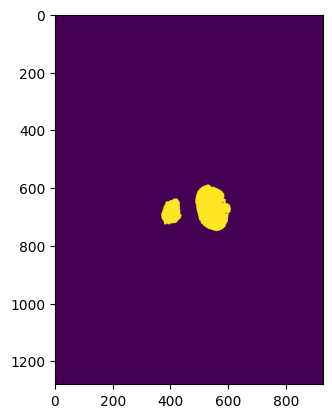

In [12]:
import matplotlib.pyplot as plt

plt.imshow(lazy_seg[0, 0, 10, ...], vmin=0, vmax=1)
plt.show()

In [ ]:
# for i, sample in enumerate(zarr_data_loader):
#     block = sample.batch_tensor[None, ...].to(cuda_device)
#     pred_mask, prob_mask = segmentation_model.predict(
#         batch=block,
#         threshold=0.5,
#     )

#     (
#         global_coord_pos,
#         global_coord_positions_start,
#         global_coord_positions_end,
#     ) = recover_global_position(
#         super_chunk_slice=sample.batch_super_chunk[0],
#         internal_slices=sample.batch_internal_slice,
#     )

#     global_coord_positions_start = np.array(global_coord_positions_start[0])
#     global_coord_positions_end = np.array(global_coord_positions_end[0])

#     # start_condition = np.where(
#     #     (global_coord_positions_start > 0) &
#     #     (global_coord_positions_start != shape)
#     # )[0]

#     # global_coord_positions_start[start_condition] += (axis_pad * (2**len(start_condition)))

#     # end_condition = np.where(
#     #     (global_coord_positions_end > 0) &
#     #     (global_coord_positions_end != shape)
#     # )[0]

#     # global_coord_positions_end[start_condition] += (axis_pad * (2**len(start_condition)))

#     start_condition = np.where(
#         (global_coord_positions_start == 0)
#     )[0]

#     if len(start_condition) == len(shape):
#         new_global_stop = global_coord_positions_end

#     else:
        
        

#     new_global_coords = []
#     for i in range(len(global_coord_positions_start)):
#         new_global_coords.append(
#             slice(
#                 global_coord_positions_start[i],
#                 global_coord_positions_end[i],
#             )
#         )

#     new_global_coords = (slice(0, 1), slice(0, 1), ) + tuple(new_global_coords)

#     # output_intermediate_seg[new_global_coords] = pred_mask
    
#     # print(global_coord_positions_start, global_coord_positions_end, global_coord_pos, new_global_coords, shape)

#     # Pinned?: {sample.batch_tensor.is_pinned()} - dtype: {sample.batch_tensor.dtype}
    
#     print(
#         f"Tensor shape: {sample.batch_tensor.shape} - Pred mask -> {pred_mask.shape} Global coords: {global_coord_pos} - new global {new_global_coords}"
#     )

In [20]:
position = np.array([120, 120, 120])
shape = np.array([512, 1408, 1024])

condition = np.where( (position > 0) & (position != shape) )[0]
position[condition]

array([120, 120])